# Analysis of Reddit Comments on Climate Change
This notebook analyzes Reddit comments on climate change. Our team's goal is to: ...

SENG 550 Final Project
- Monmoy Maahdie
- Smitkumar Saraiya
- Farhan Ali
- Kai Ferrer

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from collections import Counter
from pyspark.sql.functions import col, length, regexp_replace, udf, split, explode
from pyspark.sql.types import DoubleType, StringType, IntegerType

from pyspark.ml.feature import Tokenizer, HashingTF, VectorAssembler, StopWordsRemover
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import from_unixtime

import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2024-12-19 18:08:53.106625: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 18:08:53.107072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 18:08:53.109031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 18:08:53.114263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734656933.123135   85460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734656933.12

## 2. Create Spark Session

In [2]:
# Initialize spark session
spark = SparkSession.builder \
    .appName("Reddit Climate Change Comments") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 18:08:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 3. Load Data

In [3]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
len(stopwords)

326

## 4. Data Cleaning

In [4]:
nlp.Defaults.stop_words -= {"no", "not"}

In [5]:
# Create dataframe
df = spark.read.csv("the-reddit-climate-change-dataset-comments.csv", header=True, inferSchema=True)
df = df.repartition(100)  #  increase the number of partitions for large dataset
# df.show(5, truncate=False) # checking the dataset by displaying first 5 rows
df_original = df # save original dataset

In [6]:
new_columns = [col_name.replace('.', '_') for col_name in df.columns]
df = df.toDF(*new_columns)
# df.show(5, truncate=False)

In [7]:
df_clean = df.dropna()
# df_clean.show(n=5, truncate=False)

In [8]:
df_clean = df_clean.drop("permalink")

# Separate records where sentiment and score can be cast to numbers
clean_df = df_clean.filter(
    col("sentiment").cast(DoubleType()).isNotNull() &
    col("score").cast(DoubleType()).isNotNull()
)

# Records where either sentiment or score contain non-numerical values
problematic_df = df_clean.filter(
    col("sentiment").cast(DoubleType()).isNull() |
    col("score").cast(DoubleType()).isNull()
)


In [9]:
# clean_df.filter((df_clean["type"] == "comment") & (df_clean["subreddit_name"] == "technology")).show(n=100, truncate=False) | YOU CAN MIDIFY THE SUBREDDIT NAME TO SEE CLIMATE CHANGE DISCUSSIONS ON DIFFERENT SUBREDDITS
# clean_df.show(n=10, truncate=False) # we want this data

In [10]:
# print(clean_df.count())

In [11]:
# problematic_df.filter(df_clean["type"] == "comment").show(n=5, truncate=False) # this we do not need

## 4. Data Transformation
We start off by tokenizing the data using a spaCy model.
Then, we apply transformations to process the text.

In [12]:
clean_df_1 = clean_df.filter(col("type") == "comment") # only comments exist in here
# clean_df_1.show(n=10, truncate=False)

In [13]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Define the preprocessing function
def preprocess(comment):
    doc = nlp(comment)
    processed_words_list = []
    for token in doc:
        if not token.is_punct and not token.like_url and not token.is_stop:
            processed_words_list.append(token.lemma_.strip().lower())
    return ' '.join(processed_words_list)

    
# Create a UDF from the function
preprocess_udf = udf(preprocess, StringType())


In [14]:
# Apply the UDF to create a new column
clean_df_2 = clean_df_1.withColumn('processed_body', preprocess_udf(col('body')))
clean_df_2.show(n=5, truncate=False)

+-------+-------+------------+--------------+--------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now, we are categorizing sentiments across 3 classes: negative, neutral, and positive sentiments. This is a necessary step as part of data transformation.

In [15]:
def create_label(sentiment):
    if float(sentiment) < -0.05:
        return -1
    elif float(sentiment) >= -0.05 and float(sentiment) <= 0.05:
        return 0
    else:
        return 1

create_label_udf = udf(create_label, IntegerType())


In [16]:
clean_df_3 = clean_df_2.withColumn('label', create_label_udf(col('sentiment')))
# Count occurrences of each subreddit_name and order by count in descending order
subreddit_counts = clean_df_3.groupBy('subreddit_name') \
    .count() \
    .orderBy('count', ascending=False)

# Show the results


In [17]:
# print("Most common subreddits:")
# subreddit_counts.show(10, truncate=False)

In [18]:
# # If you need the total number of unique subreddits
# unique_subreddits = subreddit_counts.count()
# print(f"\nTotal number of unique subreddits: {unique_subreddits}")

In [19]:
# subreddit_counts.filter(subreddit_counts['subreddit_name'] == 'climate').show()
clean_df_3 = clean_df_3.withColumn("sentiment", col("sentiment").cast(DoubleType()))


In [20]:

# print("At tokenizer")
# # Tokenize comment text
# tokenizer = Tokenizer(inputCol="processed_body", outputCol="words")

# # Transform words into numerical features
# print("At hashingTF")
# hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=10000)

# # Define the model
# print("At linear regression")
# lr = LinearRegression(featuresCol="features", labelCol="sentiment")

# # Create a pipeline
# print("At pipeline")
# pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# # Split the data
# print("Data split")
# (train_data, test_data) = clean_df_3.randomSplit([0.01, 0.01])

# # Train the model
# print("model traiing")
# model = pipeline.fit(train_data)

# # Make predictions
# print("Predictions")
# predictions = model.transform(test_data)

# # Evaluate the model
# print("Mordel eval")
# evaluator = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE) on test data =", rmse)


## 5. Data Analysis & Visualization

In [21]:
clean_df_3.show(5, truncate=False)

+-------+-------+------------+--------------+--------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

24/12/19 18:09:10 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----+------+
|label| count|
+-----+------+
|   -1|221710|
|    1|196212|
|    0| 73533|
+-----+------+



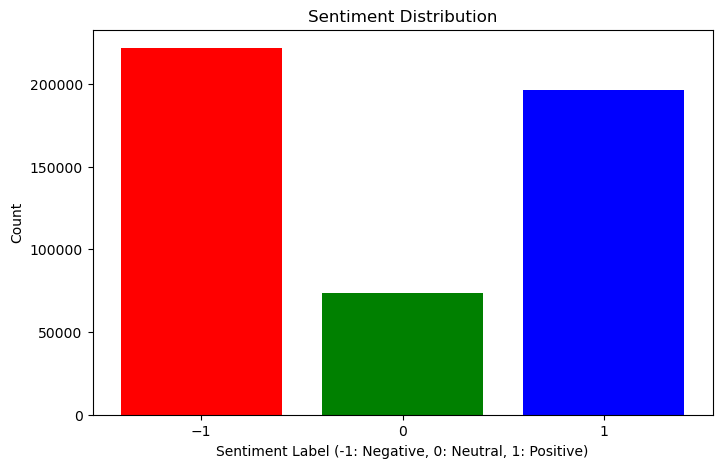

In [22]:
# Distribution of sentiment
sentiment_distribution = clean_df_3.groupBy('label').count() # Aggregation
sentiment_distribution.show()

sentiment_pd = sentiment_distribution.toPandas() #convert to pandas

# Graph
plt.figure(figsize=(8, 5))
plt.bar(sentiment_pd['label'], sentiment_pd['count'], color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.xticks(sentiment_pd['label'])
plt.show()

+--------------+-----+
|subreddit_name|count|
+--------------+-----+
|     askreddit|28643|
|     worldnews|24793|
|      politics|15214|
|      collapse|13628|
|    conspiracy| 9308|
|   environment| 8839|
|          news| 8292|
|        canada| 7355|
|    futurology| 6295|
|    neoliberal| 5953|
+--------------+-----+
only showing top 10 rows



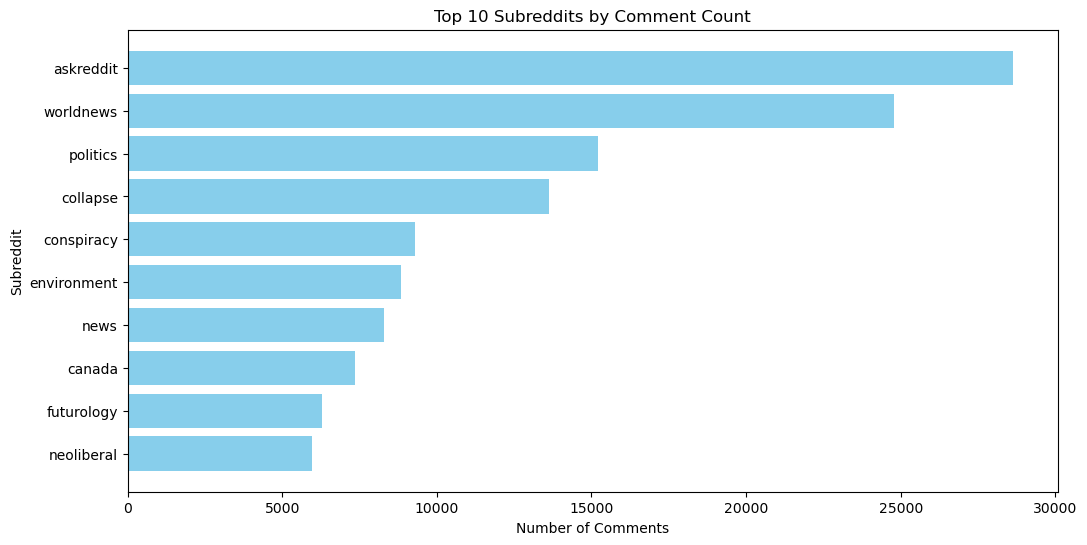

In [23]:
# Top Subreddits by Comments
# Group by subreddit_name and count occurrences
subreddit_counts = clean_df_3.groupBy('subreddit_name').count().orderBy('count', ascending=False)
subreddit_counts.show(10)
subreddit_pd = subreddit_counts.limit(10).toPandas()

# Graph
plt.figure(figsize=(12, 6))
plt.barh(subreddit_pd['subreddit_name'], subreddit_pd['count'], color='skyblue')
plt.title('Top 10 Subreddits by Comment Count')
plt.xlabel('Number of Comments')
plt.ylabel('Subreddit')
plt.gca().invert_yaxis()
plt.show()

+----------+--------------------+
|      date|   average_sentiment|
+----------+--------------------+
|2021-05-02|-0.03580107197549...|
|2021-05-03|-0.00929129172714...|
|2021-05-04| -0.0353506129597198|
|2021-05-05|-0.00237381703470...|
|2021-05-06|-0.03327734265734265|
|2021-05-07|-0.05340483005366728|
|2021-05-08|0.022720526315789476|
|2021-05-09|-0.01173386524822...|
|2021-05-10|-0.03480850393700...|
|2021-05-11|-0.04821552346570396|
|2021-05-12|-0.06504837133550488|
|2021-05-13|-0.01709604130808...|
|2021-05-14|0.003049840255591058|
|2021-05-15|-0.08891040650406504|
|2021-05-16|-0.02311151385927...|
|2021-05-17|-0.05726053240740742|
|2021-05-18|-0.03515240384615385|
|2021-05-19|-0.04121307189542483|
|2021-05-20|-0.02818316430020...|
|2021-05-21|0.004087321428571427|
+----------+--------------------+
only showing top 20 rows



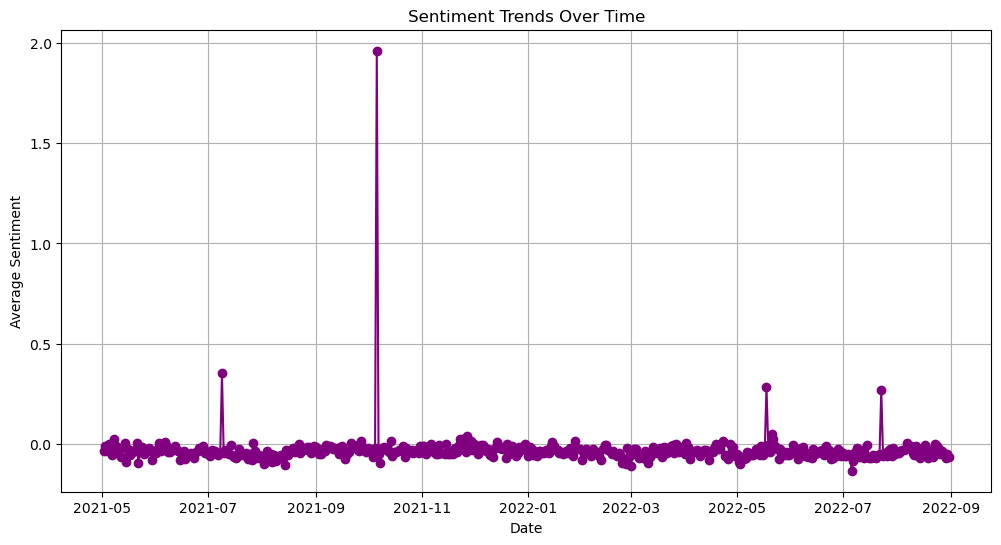

In [24]:
# Sentiment over time
# Ensure created_utc is cast to long
clean_df_3 = clean_df_3.withColumn("created_utc", col("created_utc").cast("long"))

# Convert created_utc to a date column
def convert_to_date(timestamp):
    return pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d')

convert_to_date_udf = udf(convert_to_date, StringType())
clean_df_3 = clean_df_3.withColumn('date', convert_to_date_udf(col('created_utc')))

# Group by date and calculate average sentiment
sentiment_trends = clean_df_3.groupBy('date').agg({'sentiment': 'mean'}).orderBy('date')
sentiment_trends = sentiment_trends.withColumnRenamed('avg(sentiment)', 'average_sentiment')
sentiment_trends.show()

# Convert to Pandas for visualization
trends_pd = sentiment_trends.toPandas()
trends_pd['date'] = pd.to_datetime(trends_pd['date'])

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(trends_pd['date'], trends_pd['average_sentiment'], color='purple', marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


## This is supposed to be the ML implementation of whatever we doing lmao

In [25]:
df_ml = clean_df_3.toPandas()


texts = df_ml['processed_body'].values
labels = df_ml['label'].values


In [26]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [27]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [28]:
# Convert labels to categorical
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    encoded_labels, 
    test_size=0.2, 
    random_state=42
)


In [30]:
# Build the model
model = Sequential([
    Embedding(10000, 32, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])


/home/csusers/smitkumar.saraiya/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-19 18:14:17.608800: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [31]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
# Train the model with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 220s 22ms/step - accuracy: 0.7665 - loss: 0.5680 - val_accuracy: 0.8579 - val_loss: 0.4035
Epoch 2/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 218s 22ms/step - accuracy: 0.8676 - loss: 0.3833 - val_accuracy: 0.8620 - val_loss: 0.3911
Epoch 3/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 216s 22ms/step - accuracy: 0.8764 - loss: 0.3587 - val_accuracy: 0.8649 - val_loss: 0.3905
Epoch 4/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 218s 22ms/step - accuracy: 0.8820 - loss: 0.3410 - val_accuracy: 0.8634 - val_loss: 0.3972
Epoch 5/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 219s 22ms/step - accuracy: 0.8896 - loss: 0.3173 - val_accuracy: 0.8612 - val_loss: 0.4074
Epoch 6/10
9830/9830 ━━━━━━━━━━━━━━━━━━━━ 218s 22ms/step - accuracy: 0.8973 - loss: 0.2970 - val_accuracy: 0.8581 - val_loss: 0.4248


In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}")

# Function to predict sentiment for new text
def predict_sentiment(text):
    # Preprocess the text similarly to training data
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_class[0]

3072/3072 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.8668 - loss: 0.3847
Test accuracy: 86.57


In [44]:
#Save some example predictions
example_texts = [
    "climate change is a serious threat to our planet",
    "we need to take action on environmental issues",
    "this climate change discussion is pointless"
]

print("\nExample predictions:")
for text in example_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment}\n")



Example predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Text: climate change is a serious threat to our planet
Predicted sentiment: -1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Text: we need to take action on environmental issues
Predicted sentiment: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Text: this climate change discussion is pointless
Predicted sentiment: 0



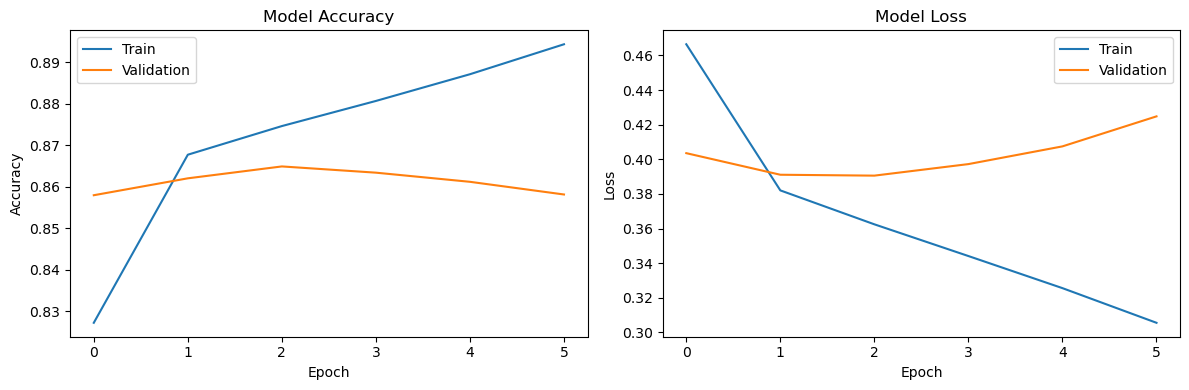

In [35]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [45]:
# Interactive prediction
while True:
    try:
        x = int(input("\nEnter a number between 0 and 491454 inclusive (or -1 to exit): "))
        if x == -1:
            break
        if 0 <= x <= 491454:
            sentiment = predict_sentiment(texts[x])
            print(f"\nText: {texts[x]}")
            print(f"Predicted sentiment: {sentiment}")
            # Also print the actual sentiment for comparison
            print(f"Actual sentiment: {labels[x]}")
        else:
            print("Number out of range. Please enter a valid number.")
    except ValueError:
        print("Please enter a valid integer.")
    except IndexError:
        print("Index out of range. Please enter a valid number.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Text: jfc gd bus lane folk tobin time drive nut go tackle climate change public transit fast appealing
Predicted sentiment: -1
Actual sentiment: -1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Text: no need nuke doc personal research fight climate change think joke nuke hurricane /s
Predicted sentiment: -1
Actual sentiment: -1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Text: democrats happy clean bill add bullshit taxis climate change second try pull fast amp party look like say no veteran
Predicted sentiment: 1
Actual sentiment: -1
Number out of range. Please enter a valid number.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Text: critical danger think solution outside extreme government intervention ignore thing like technological advancement likely continue happen climate change kill humanity
Predicted sentiment: -1
Actual sentiment: -1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Text: kinda go reservation climate change deni book unfortunately state fear
Predicted

## STOP HEHE

In [36]:
spark.stop()